# Liquidation Ratio Analysis

## Purpose
Expore how diffenent liquidation ratios affect the risk of bad-debt creation in the Reflexer system by simulating *instantaneous* ETH/USD shocks.

In [1]:
import time
import math
import pandas as pd
import numpy as np
import requests
import json
import multiprocess
from multiprocess import Pool
from decimal import Decimal
import matplotlib.pyplot as plt
import scipy.stats as ss
from sklearn.preprocessing import PowerTransformer

import seaborn as sns
from fitter import Fitter, get_common_distributions, get_distributions

from uniswap import get_input_price, get_output_price, buy_to_price
from graph_util import fetch_safes, fetch_rp, fetch_debt_ceiling
from util import chunks

In [2]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 

# Historical ETH Shocks

First, let's explore the size of historical ETH/USD shocks in the Maker oracle and also in Binance ETH/USDT data.

## Historical Hourly MKR OSM shocks from 2020-08-06 to 2021-09-07

In [3]:
df = pd.read_csv('mkr_osm_int.csv')
df['price'] = df['price'].astype(float)/10E17

# order by time
df = df.sort_values('ts')

# pct change from previous ts
df['pct_change'] = df['price'].pct_change()

### Largest hourly pct drops 

In [4]:
# show largest pct drops
df.sort_values('pct_change').head(5)

,block,ts,price,pct_change
2464,12422932,2021-05-13 01:02:06 UTC,3831.000000,-0.095507
2279,12472770,2021-05-20 18:05:07 UTC,2687.000000,-0.083279
2211,12490963,2021-05-23 14:01:18 UTC,1930.231566,-0.083112
4350,11912604,2021-02-23 10:00:00 UTC,1470.200000,-0.080550
2306,12465534,2021-05-19 15:05:05 UTC,2440.160000,-0.071116


### Quantiles

In [5]:
df['pct_change'].quantile(0.01), df['pct_change'].quantile(0.001), df['pct_change'].quantile(0.0001)

(-0.034568015169454853, -0.0597010511121509, -0.08430029098011962)

## Historical Hourly Binance ETH/USDT Shocks from 2017-08-17 to 2021-09-07

In [6]:
df = pd.read_csv('Binance_ETHUSDT_1h.csv')
df['range'] = df['high'] - df['low']
df['pct_change'] = (df['low']/df['high']) - 1
print(f"Number of hourly ticks {len(df)}")

Number of hourly ticks 38194


### Largest hourly pct drops in ETH/USDT

In [7]:
df.sort_values('pct_change', ascending=True)[['date', 'close', 'Volume ETH', 'pct_change']].head(5)

,date,close,Volume ETH,pct_change
38193,2017-08-17 04-AM,300.79,122.52000,-0.543463
38073,2017-08-22 04-AM,287.00,145.21000,-0.533346
2648,2021-05-19 12:00:00,2365.18,437462.36681,-0.293317
15663,2020-03-13 02-AM,111.12,463034.33000,-0.284526
2647,2021-05-19 13:00:00,2493.69,493227.88282,-0.273567


### Quantiles

In [8]:
df['pct_change'].quantile(0.01),  df['pct_change'].quantile(0.001), df['pct_change'].quantile(0.0001)


(-0.0650481169905298, -0.13570589329157023, -0.2755470538713533)

# Historical 4-Hour MKR OSM shocks from 2020-08-06 to 2021-09-07

The Maker ETH/USD oracle is updated every hour, but the Reflexer oracle is updated every 4 hours. So lets consider what the largest 4-hour percent drop in the Maker oracle data.

In [9]:
df_mkr = pd.read_csv('mkr_osm_int.csv')
df_mkr['price'] = df_mkr['price'].astype(float)/10E17

# order by time
df_mkr = df_mkr.sort_values('ts')

# pct change from previous ts
df_mkr['pct_change'] = df_mkr['price'].pct_change(4)

### Largest 4-hour pct drops 

In [10]:
# show largest pct drops
df_mkr.sort_values('pct_change').head(5)

,block,ts,price,pct_change
2306,12465534,2021-05-19 15:05:05 UTC,2440.16,-0.176690
5548,11587865,2021-01-04 12:01:46 UTC,966.04,-0.132717
5384,11632391,2021-01-11 08:00:41 UTC,1043.40,-0.124062
5387,11631584,2021-01-11 05:01:41 UTC,1117.82,-0.121956
2307,12465262,2021-05-19 14:05:12 UTC,2626.98,-0.114541


### Quantiles

In [11]:
print(f"95%: {df_mkr['pct_change'].quantile(0.05):.2f}\n"  
      f"99%:{df_mkr['pct_change'].quantile(0.01):.2f}\n"
      f"99.9%: {df_mkr['pct_change'].quantile(0.001):.2f}\n"
      f"99.99%: {df_mkr['pct_change'].quantile(0.0001):.2f}")

95%: -0.04
99%:-0.06
99.9%: -0.10
99.99%: -0.14


## Historical 4-Hour Binance ETH/USDT Shocks from 2017-08-17 to 2021-09-07

In [12]:
df_bin = pd.read_csv('Binance_ETHUSDT_1h.csv')
df_bin['max_high'] = df_bin['high'].rolling(window=4).max()
df_bin['min_low'] = df_bin['low'].rolling(window=4).min()
df_bin['pct_change'] = (df_bin['min_low']/df_bin['max_high']) - 1
print(f"Number of hourly ticks {len(df_bin)}")

Number of hourly ticks 38194


### Largest 4-hour pct drops in ETH/USDT

In [13]:
df_bin.sort_values('pct_change', ascending=True)[['date', 'close', 'Volume ETH', 'pct_change']].head(10)

,date,close,Volume ETH,pct_change
38076,2017-08-22 01-AM,309.97,166.03000,-0.556372
38074,2017-08-22 03-AM,280.00,82.23000,-0.546053
38075,2017-08-22 02-AM,312.99,143.09000,-0.546053
38193,2017-08-17 04-AM,300.79,122.52000,-0.543463
38073,2017-08-22 04-AM,287.00,145.21000,-0.535166
15665,2020-03-13 12-AM,106.89,352204.30000,-0.376812
15664,2020-03-13 01-AM,96.62,247820.18000,-0.376812
15663,2020-03-13 02-AM,111.12,463034.33000,-0.376812
2650,2021-05-19 10:00:00,2856.56,118730.30048,-0.367396
2651,2021-05-19 09:00:00,2973.82,72815.26871,-0.347971


### Quantiles

In [14]:
print(f"95%: {df_bin['pct_change'].quantile(0.05):.2f}\n"  
      f"99%: {df_bin['pct_change'].quantile(0.01):.2f}\n"
      f"99.9%: {df_bin['pct_change'].quantile(0.001):.2f}\n"
      f"99.99%: {df_bin['pct_change'].quantile(0.0001):.2f}")


95%: -0.07
99%: -0.12
99.9%: -0.22
99.99%: -0.54


## Overview

Explore how system liquidation_ratios affect bad debt creation during ETH/USD price dops.

## Methodology

Simulate an ETH/USD price drop of X%, then use RAI from Uniswap pools to settle resulting collateral auction and determine how much bad debt is created.

## Simulations

#### 1) Mainnet collateral amounts and c-ratios

#### 2) Mainnet collateral amounts and stochastic c-ratios

#### 3) Stochastic collateral amounts and stochastic c-ratios

#### 4) Gaussian Mixture model for collateral amounts and c-ratios


## Pessimistic Assumptions
### 1) All RAI for collateral auctions is purchased from market. No RAI-holding keepers exist
### 2) Overly expensive RAI market price.  Keepers get worse deal for RAI than expected and can buy less collateral at a profit.
####     - RAI is priced at redemption price after an ETH/USD drop -> expensive RAI
####     - No RAI market selling pressure when keepers purchase RAI -> expensive RAI

### 3) Saviours not considered
### 4) V2 Pool liquidity is reduced by 50% for all shocks
### 5) 35% OSM Responsiveness to avoid liquidation
### 6) Uses static surplus. Doesn't reduce surplus over time due to negative SF

## Optimistic Assumptions
### 1) Gas price is not considered
### 2) Keeper efficiency not considered

Fetch ETH/USD price, redemption price and all Reflexer SAFEs

In [15]:
#graphql_url = 'https://subgraph.reflexer.finance/subgraphs/name/reflexer-labs/rai'
graphql_url = 'https://api.thegraph.com/subgraphs/name/reflexer-labs/rai-mainnet'
eth_usd_url = 'https://api.coingecko.com/api/v3/simple/price?ids=ethereum&vs_currencies=usd'
ETH_USD = requests.get(eth_usd_url).json()['ethereum']['usd']
REDEMPTION_PRICE = fetch_rp(graphql_url)
DEBT_CEILING = fetch_debt_ceiling(graphql_url)
orig_safes = fetch_safes(graphql_url)

# only consider SAFEs with debt
orig_safes = orig_safes.query('debt > 0').reset_index()

How much extra debt the system will allow

In [16]:
# Extra debt and collateral that can be created if debt ceiling is exhausted(use system c-ratio)
extra_debt = DEBT_CEILING  - orig_safes['debt'].sum()

## Mainnet Parameters

In [17]:
MAINNET_LIQ_RATIO = 1.40 
LIQ_PENALTY = 1.10
INITIAL_SURPLUS = 493000
MIN_DISCOUNT = 0.92
MAX_DISCOUNT = 0.90

# use max_discount for collateral_auctions
DISCOUNT = MAX_DISCOUNT
OSM_RESPONSIVENESS = 0.35 # What percent of SAFE owners avoid liquidation with OSM delay

# RAI pools
RAI_ETH_V2= 5.7E6/2
RAI_ETH_V3 = 39.6E3 
RAI_DAI_V3 = 3.02E6 
RAI_USDC_V3 = 1.1E6 

rai_v2_pool = RAI_ETH_V2 + RAI_ETH_V3
usd_v2_pool = rai_v2_pool * REDEMPTION_PRICE
rai_v3_pool = RAI_DAI_V3 + RAI_USDC_V3
usd_v3_pool = rai_v3_pool * REDEMPTION_PRICE

#### Not currently used
SURPLUS_BUFFER = 500000 # Not currently used
DISCOUNT_UPDATE_RATE = Decimal(0.999991859697312485818842992) # Not currently used
LIQUIDATION_QUANTITY = 90000.00 # Not currently used
ON_AUCTION_SYSTEM_COIN_LIMIT = 4025086.73 # Not currently used
#####


## Sim Parameters

In [18]:
N_RUNS = 1000
LRS = [1.20, 1.25, 1.30, 1.35, 1.40]
SURPLUSES = [INITIAL_SURPLUS, 1E6]

min_shock = 0.00
max_shock = 0.6
n_shocks = 61
SHOCKS = np.round(np.linspace(min_shock, max_shock, n_shocks), 4)
TOTAL_SHOCKS = [1, 2, 4, 6]

# Analysis Parameters
QUANTILES = [0.90, 0.95, 0.99]

PLOT = False
VERBOSE = False

## Define Sim Functions

In [19]:
def update_cratios(safes, eth_price, redemption_price):
    # update c-ratio based on `eth_price` and `redemption_price`
    new_safes = safes.copy()
    new_safes['cratio'] = new_safes['collateral'] * eth_price / (new_safes['debt'] * redemption_price)
    return new_safes

In [20]:
def liquidate_critical(safes, liq_cratio=1.40):
    # Return amount of collateral/debt liquidated
    critical_safes = safes.query(f'cratio < {liq_cratio}')

    critical_collateral = critical_safes['collateral'].sum()
    critical_debt = critical_safes['debt'].sum()

    return critical_collateral, critical_debt

def adjust_safe_debt_and_cratios(safes, debt_adj, eth_price, redemption_price):
    # adjust debt by `debt_adj` multiplier
    if debt_adj == 1:
        return safes
    new_safes = safes.copy()
    
    new_safes['debt'] *= debt_adj

    return update_cratios(new_safes, eth_price, redemption_price)

In [21]:
# run a single sim
def run(orig_safes, liq_ratio, shock, initial_surplus):
    
    #debt_adj =  MAINNET_LIQ_RATIO/ liq_ratio
    #safes = adjust_safe_debt_and_cratios(orig_safes, debt_adj, ETH_USD, REDEMPTION_PRICE)
    
    # Set eth shock price
    eth_shock_price = ETH_USD * (1 - shock)
    
    # update c-ratios
    safes = update_cratios(orig_safes, eth_shock_price, REDEMPTION_PRICE)

    # Liquidate all critical SAFEs
    critical_collateral, critical_debt = liquidate_critical(safes, liq_ratio)
    
    critical_collateral *= (1 - OSM_RESPONSIVENESS)
    critical_debt *= (1 - OSM_RESPONSIVENESS)
    
    amount_to_raise = critical_debt * LIQ_PENALTY
    discount_collateral_price = eth_shock_price * DISCOUNT
    
    total_collateral_cost = critical_collateral * discount_collateral_price
    
    # Use v3 pool 
    # Assume rai market = redemption price and estimate slippage
    rai_v3_market_price = REDEMPTION_PRICE * 1.005 # Estimate slippage in V3 pool.

    # Use up to the entire pool to buy discounted collateral
    v3_collateral_bought = min((rai_v3_pool * REDEMPTION_PRICE)/discount_collateral_price, critical_collateral) 

    collateral_left = critical_collateral - v3_collateral_bought

    rai_v3_spent = v3_collateral_bought * discount_collateral_price / REDEMPTION_PRICE

    amount_raised_v3 = rai_v3_spent

    if collateral_left == 0:
        amount_deficit = critical_debt - amount_raised_v3
    
    else: # then use V2 pool

        amount_left_to_raise = amount_to_raise - rai_v3_spent

        collateral_left_cost = collateral_left * discount_collateral_price

        # max price to pay for RAI to make a profit on discounted collateral
        max_market_price = REDEMPTION_PRICE / DISCOUNT

        # Max amount to buy to put cost-basis at `max_market_price`
        how_much_v2_can_buy = 2 * buy_to_price(None, rai_v2_pool, goal_price=max_market_price, market_price=REDEMPTION_PRICE)

        # how is the pool affected when with this swap
        # This just confirms the expected final market price
        #delta_usd, delta_rai = get_output_price(how_much_v2_can_buy, usd_v2_pool, rai_v2_pool, trade_fee=0.003)
        # new market price
        #print(f"market price after buy {(usd_v2_pool + delta_usd)/(rai_v2_pool + delta_rai):.2f}")

        amount_raised_v2 = min(amount_left_to_raise, how_much_v2_can_buy)

        amount_deficit = critical_debt - amount_raised_v2 - amount_raised_v3

    return initial_surplus - amount_deficit

In [22]:
# run many sims
def run_sims(safes, title='', sim_name='', verbose=False, plot=False):
    assert len(safes) == N_RUNS
    all_shocks = []
    all_surplus = []
    all_results = []
    
    for lr in LRS:
        # `debt_adj` is used to adjust individual SAFE debt to match expected values when liq_ratio is changed
        # This preserves safe debt as a multiplier of liq_ratio
        debt_adj =  MAINNET_LIQ_RATIO/ lr
        lr_safes = adjust_safe_debt_and_cratios(safes, debt_adj, ETH_USD, REDEMPTION_PRICE)
        
        for initial_surplus in SURPLUSES:
            config_shocks = []
            config_surpluses = []
            
            for i in range(N_RUNS):
                run_safes = lr_safes[i]
                lr_surpluses = []
                
                for s in SHOCKS:
                    surplus = run(run_safes, lr, s, initial_surplus)                    
                    config_shocks.append(s)
                    config_surpluses.append(surplus)
                    
                    if s == 0.0 and surplus < 0:
                        raise ValueError("negative surplus at zero shock")
                    
                    all_shocks.append(s)
                    all_surplus.append(surplus)
                    
                    if plot:
                        lr_surpluses.append(surplus)

                if plot:
                    plt.plot(SHOCKS, lr_surpluses, alpha=0.1)

            df = pd.DataFrame({'sim_name': sim_name, 'lr': lr, 'initial_surplus': initial_surplus, 
                               'shock': config_shocks,  'surplus': config_surpluses})
            all_results.append(df)

            for q in QUANTILES:
                if verbose:
                    df_q = df[['shock', 'surplus']].groupby('shock').quantile(1. - q).reset_index()
                    zero_q = df_q[df_q['surplus'] > 0].sort_values('surplus')

                    zero_debt_q = zero_q.iloc[0]['shock']
                    print(f"{lr}, {initial_surplus}, {q}, {zero_debt_q:.3f}")

                if plot:
                    df_100 = df[['shock', 'surplus']].groupby('shock').quantile(1.0).reset_index()
                    plt.plot(df_q['shock'], df_q['surplus'], ':')
                    plt.plot(df_100['shock'], df_100['surplus'], ':')
                    plt.fill_between(SHOCKS, 
                                df_100['surplus'], 
                                df_q['surplus'], alpha=0.4,label=f"{q*100}% confidence")

            if plot:
                df_mean = df[['shock', 'surplus']].groupby('shock').mean().reset_index()
                plt.plot(df_mean['shock'], df_mean['surplus'])
                plt.title(f'{title}\n{lr=}, {initial_surplus=} {N_RUNS=}', fontsize=14)
                plt.xlabel('ETH/USD Shock (0.5 = 50% drop)', fontsize=16)
                plt.ylabel('Debt', fontsize=16)
                plt.grid(True)
                plt.legend(loc='lower left')
                plt.ylim([-1E7,2E6])
                plt.show()
                
    return pd.concat(all_results)
    #return pd.DataFrame(results, columns=['sim_name', 'lr', 'initial_surplus', 'q', 'final_surplus'])


In [23]:
# run many sims over multiple subsequent shocks
def run_sims_iter(safes, total_shocks=5, title='', sim_name='', verbose=False, plot=False):
    assert len(safes) == N_RUNS
    all_shocks = []
    all_surplus = []
    all_results = []
    
    for lr in LRS:
        # `debt_adj` is used to adjust individual SAFE debt to match expected values when liq_ratio is changed
        # This preserves safe debt as a multiplier of liq_ratio
        debt_adj =  MAINNET_LIQ_RATIO/ lr
        lr_safes = [adjust_safe_debt_and_cratios(safe, debt_adj, ETH_USD, REDEMPTION_PRICE) for safe in safes]
        for initial_surplus in SURPLUSES:
            config_shocks = []
            config_surpluses = []
            
            for i in range(N_RUNS):
                run_safes = lr_safes[i]
                lr_surpluses = []               
                for s in SHOCKS:
                    total_shocks_run = 0
                    surplus = initial_surplus
                    while total_shocks_run < total_shocks:
                        surplus = run(run_safes, lr, s, surplus)
                        total_shocks_run += 1 
                            
                    config_shocks.append(s)
                    config_surpluses.append(surplus)
                    
                    if s == 0.0 and surplus < 0:
                        raise ValueError("negative surplus at zero shock")
                    
                    all_shocks.append(s)
                    all_surplus.append(surplus)
                    
                    if plot:
                        lr_surpluses.append(surplus)

                if plot and N_RUNS < 100: # Plotting too many runs is slow
                    plt.plot(SHOCKS, lr_surpluses, alpha=0.1)

            df = pd.DataFrame({'sim_name': sim_name, 'lr': lr, 'initial_surplus': initial_surplus, 
                               'shock': config_shocks,  'surplus': config_surpluses})
            
            all_results.append(df)
        
            for q in QUANTILES:
                if verbose:
                    df_q = df[['shock', 'surplus']].groupby('shock').quantile(1. - q).reset_index()
                    zero_q = df_q[df_q['surplus'] > 0].sort_values('surplus')

                    zero_debt_q = zero_q.iloc[0]['shock']
                    print(f"{sim_name=}, {lr=}, {initial_surplus=}, {q=}, {zero_debt_q=:.3f}")

                if plot and len(QUANTILES) <= 10:
                    df_100 = df[['shock', 'surplus']].groupby('shock').quantile(1.0).reset_index()
                    plt.plot(df_q['shock'], df_q['surplus'], ':')
                    plt.plot(df_100['shock'], df_100['surplus'], ':')
                    plt.fill_between(SHOCKS, 
                                df_100['surplus'], 
                                df_q['surplus'], alpha=0.4,label=f"{q*100}% confidence")

            if plot:
                df_mean = df[['shock', 'surplus']].groupby('shock').mean().reset_index()
                plt.plot(df_mean['shock'], df_mean['surplus'])
                plt.title(f'{title}\n{lr=}, {initial_surplus=} {N_RUNS=}', fontsize=14)
                plt.xlabel('ETH/USD Shock (0.5 = 50% drop)', fontsize=16)
                plt.ylabel('Debt', fontsize=16)
                plt.grid(True)
                plt.legend(loc='lower left')
                plt.ylim([-1E7,2E6])
                plt.show()
                
    return pd.concat(all_results)


# Sim #1: Mainnet SAFE Collateral Amounts and C-ratios

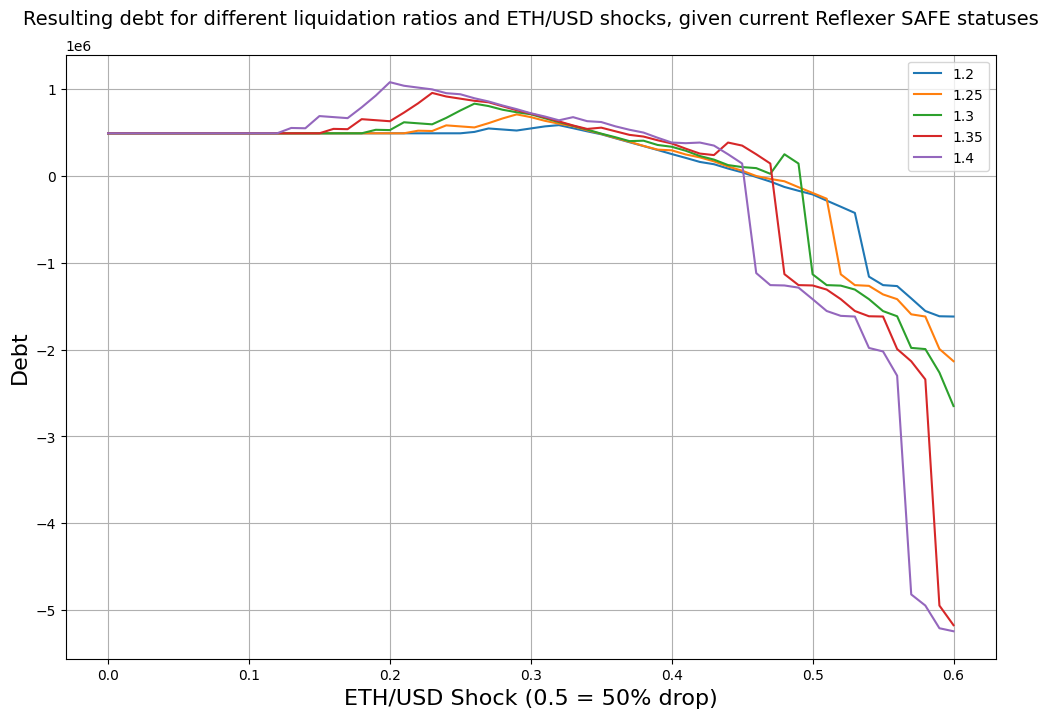

In [24]:
for lr in LRS:    
    lr_surpluses = []
    for s in SHOCKS:
        surplus = run(orig_safes, lr, s, initial_surplus=INITIAL_SURPLUS)
        lr_surpluses.append(surplus)
    plt.plot(SHOCKS, lr_surpluses, label=lr)
    
plt.legend()
plt.title('Resulting debt for different liquidation ratios and ETH/USD shocks, given current Reflexer SAFE statuses\n', fontsize=14)
plt.xlabel('ETH/USD Shock (0.5 = 50% drop)', fontsize=16)
plt.ylabel('Debt', fontsize=16)
plt.grid(True)
plt.show()

# Sim #2: Mainnet SAFE Collateral Amounts with Stochastic C-ratios

### Examine mainnet c-ratios

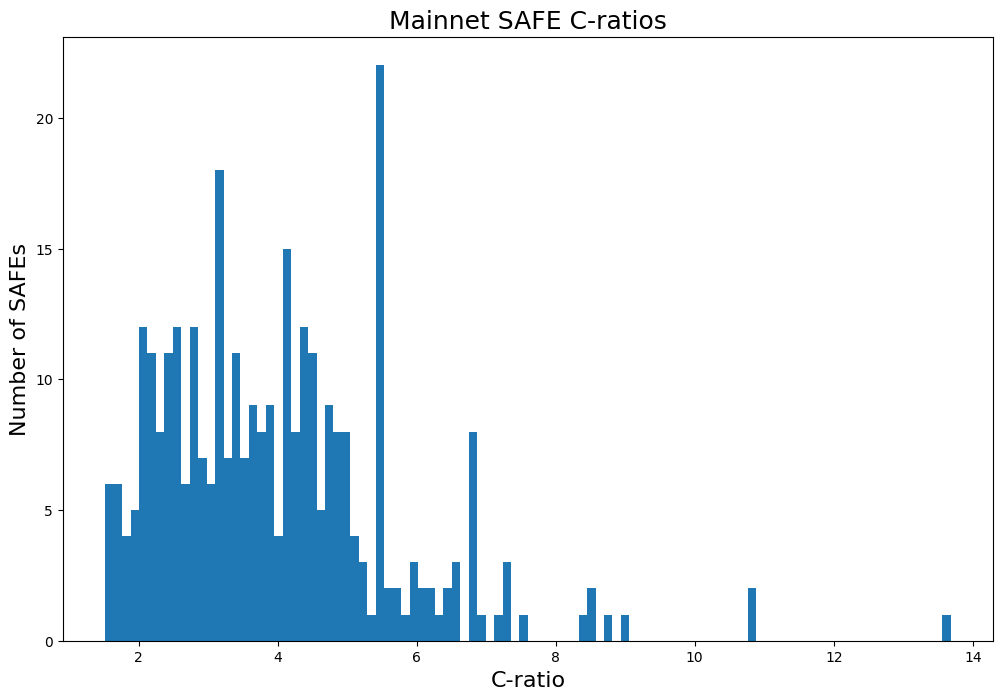

In [25]:
orig_safes = update_cratios(orig_safes, ETH_USD, REDEMPTION_PRICE)
orig_safes['cratio'].hist(bins=100)
plt.title('Mainnet SAFE C-ratios', fontsize=18)
plt.xlabel('C-ratio', fontsize=16)
plt.ylabel('Number of SAFEs', fontsize=16)
plt.grid(False)
plt.show()

### Fit many distributions to mainnnet c-ratios

/Users/georgekellerman/github/geb-data-science/venv/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:4837: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  intg = integrate.quad(f, -xi, np.pi/2, **intg_kwargs)[0]
/Users/georgekellerman/github/geb-data-science/venv/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


,sumsquare_error,aic,bic,kl_div
mielke,0.438022,809.915749,-2124.890587,inf
burr,0.438023,809.907823,-2124.890209,inf
chi,0.446770,895.422201,-2124.247974,inf
nakagami,0.446774,895.393950,-2124.245045,inf
genexpon,0.450172,813.881917,-2110.215031,inf


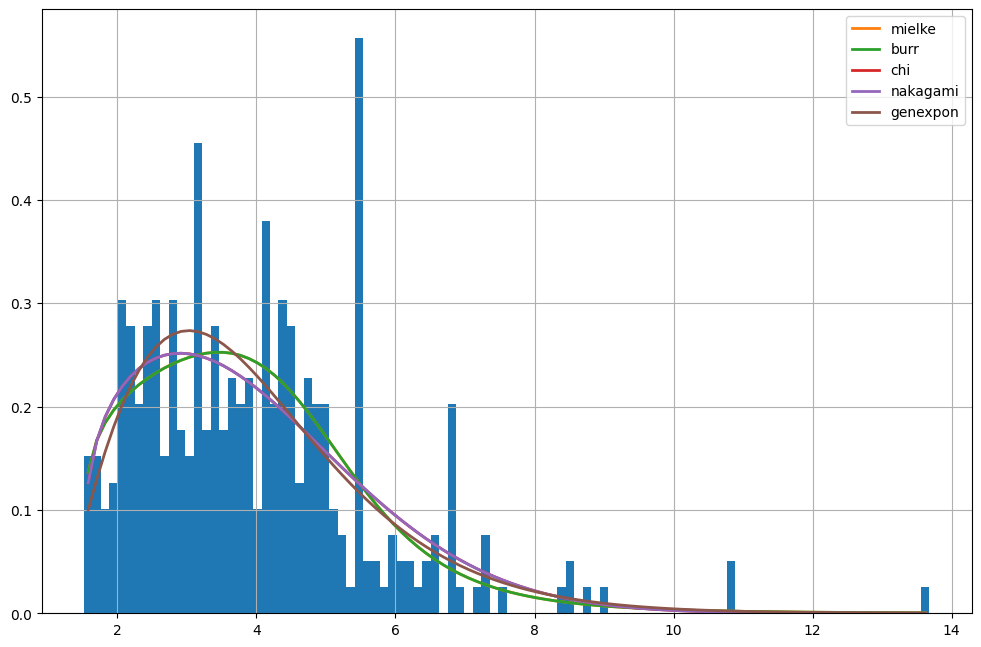

In [26]:
fitter_cratio = Fitter(orig_safes['cratio'].values)          
fitter_cratio.fit()
fitter_cratio.summary()

### Pick the best distribution and generate some c-ratios

In [27]:
# best_cratio = fitter_cratio.get_best(method = 'sumsquare_error')
cratio_params = fitter_cratio.fitted_param["mielke"]

/Users/georgekellerman/github/geb-data-science/venv/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


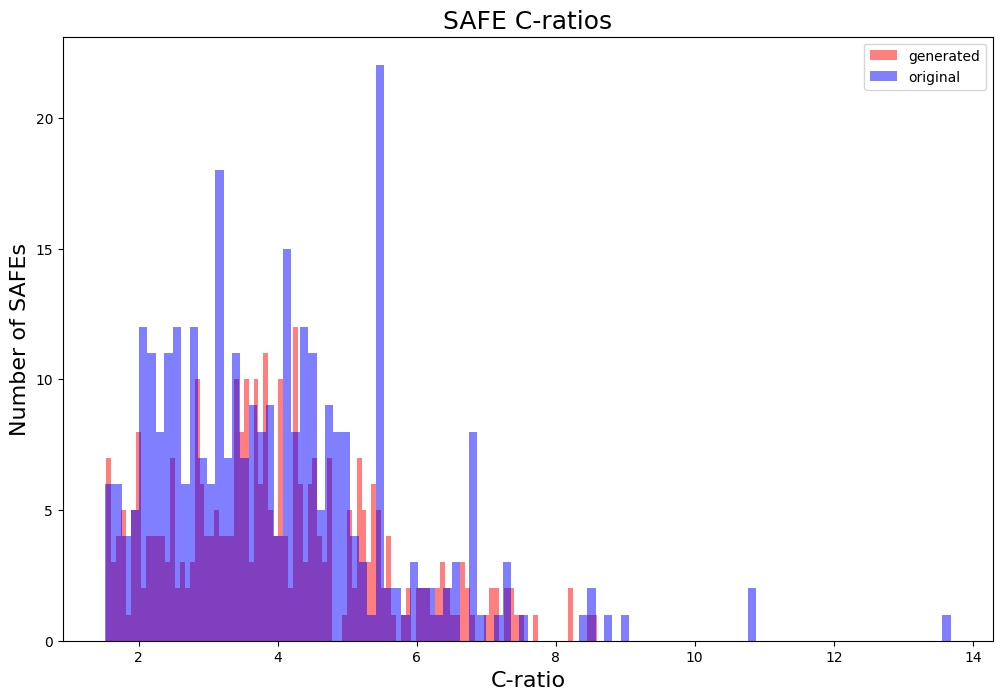

In [28]:
cratios_r = ss.mielke.rvs(*cratio_params, size=len(orig_safes)*2)
cratios_r = cratios_r[cratios_r > MAINNET_LIQ_RATIO]

df = pd.DataFrame(cratios_r, columns=['cratio'])
df = df.head(len(orig_safes))

df['cratio'].hist(bins=100, alpha=0.5, color='red', label='generated')

orig_safes['cratio'].hist(bins=100, color='blue', alpha=0.5, label='original')

plt.title('SAFE C-ratios', fontsize=18)
plt.xlabel('C-ratio', fontsize=16)
plt.ylabel('Number of SAFEs', fontsize=16)
plt.legend()
plt.grid(False)
plt.show()

# Sim #2: Mainnet SAFE collateral amounts with stochastic c-ratios

### Prepare SAFEs

In [29]:
all_cratios = []
for _ in range(N_RUNS):
    all_cratios.append(ss.mielke.rvs(*cratio_params, size=len(orig_safes)*2))

cratio_rv = ss.mielke(*cratio_params)

all_tmp_safes = [pd.DataFrame(cr, columns=['cratio']) for cr in all_cratios]

final_sim2_safes = []
for tmp_safes in all_tmp_safes:
    tmp_safes = tmp_safes[tmp_safes['cratio'] > MAINNET_LIQ_RATIO]        
    tmp_safes = tmp_safes.head(len(orig_safes))
    assert len(tmp_safes) == len(orig_safes)

    tmp_safes['collateral'] = orig_safes['collateral']
    tmp_safes['debt'] = tmp_safes['collateral'] * ETH_USD / REDEMPTION_PRICE / tmp_safes['cratio']

    # Consider debt ceiling, adding more possible debt
    added_debt = 0
    while added_debt < extra_debt:
        new_cr = cratio_rv.rvs(size=1)[0]
        while new_cr < MAINNET_LIQ_RATIO: 
            new_cr = cratio_rv.rvs(size=1)[0]
            
        new_coll = orig_safes['collateral'].sample().iloc[0]

        new_debt = min(new_coll * ETH_USD / REDEMPTION_PRICE / new_cr, extra_debt - added_debt)
        added_debt += new_debt
        tmp_safes = tmp_safes.append({'cratio': new_cr, 'collateral': new_coll, 'debt': new_debt}, ignore_index=True)
        
    final_sim2_safes.append(tmp_safes)        
    assert added_debt == extra_debt

# Sim #3: Stochastic SAFE collateral amounts and stochastic c-ratios

### Fit many distributions to mainnnet collateral amounts

/Users/georgekellerman/github/geb-data-science/venv/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


,sumsquare_error,aic,bic,kl_div
laplace_asymmetric,1.347625,564.393613,-1765.430063,inf
skewcauchy,1.391076,593.463730,-1755.116477,inf
exponnorm,1.421485,558.751264,-1748.088422,inf
skewnorm,1.462578,558.743758,-1738.826543,inf
nakagami,1.477267,inf,-1735.578733,inf


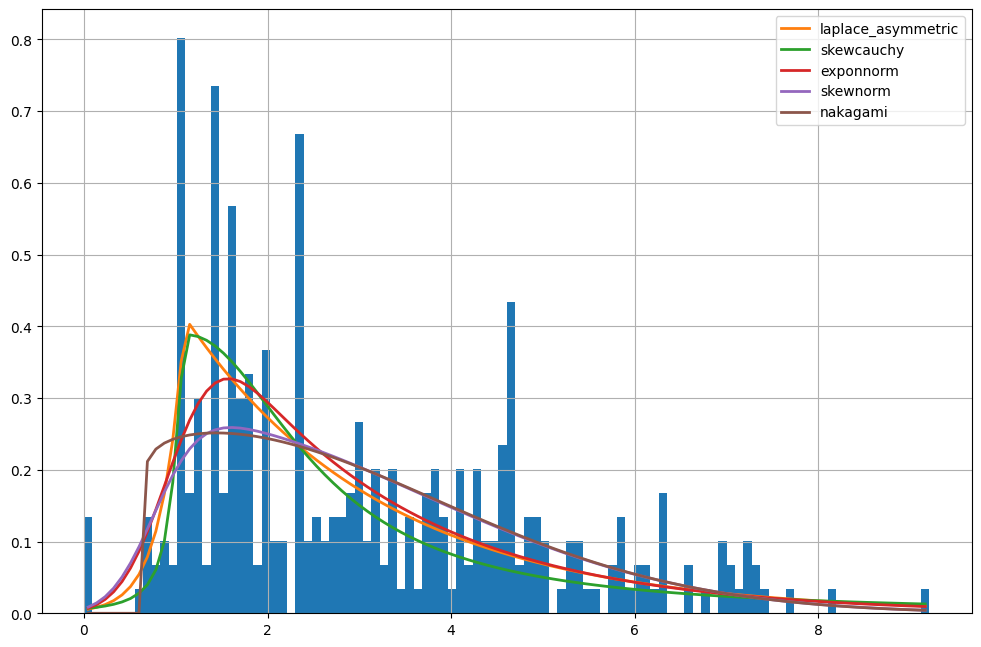

In [30]:
fitter_coll = Fitter(np.log(orig_safes['collateral'].values))        
fitter_coll.fit()
fitter_coll.summary()

### Pick the best distribution and generate some collateral amounts

In [31]:
#best_coll = fitter_coll.get_best(method = 'sumsquare_error')
coll_params = fitter_coll.fitted_param["skewcauchy"]

/Users/georgekellerman/github/geb-data-science/venv/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


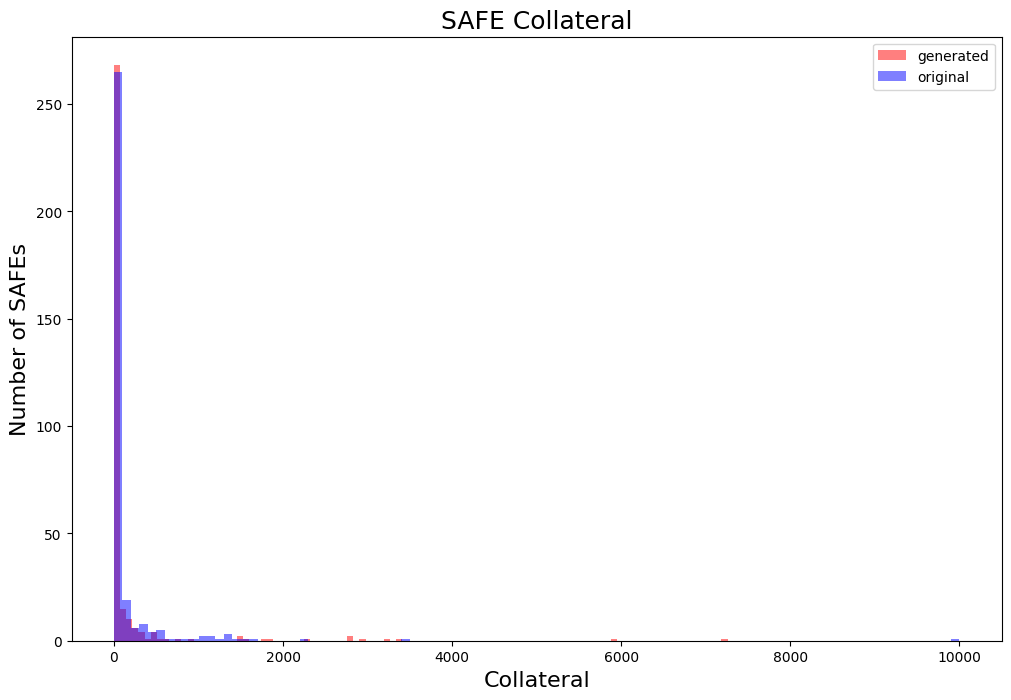

In [32]:
colls_r = ss.skewcauchy.rvs(*coll_params, size=len(orig_safes)*2)

colls_r = np.exp(colls_r)

# Collateral

df = pd.DataFrame(colls_r, columns=['collateral'])
df = df[(df['collateral'] > 0) & (df['collateral'] < orig_safes['collateral'].max()) & (tmp_safes['cratio'] > MAINNET_LIQ_RATIO)]
df = df.head(len(orig_safes))

df['collateral'].hist(bins=100, alpha=0.5, color='red', label='generated')

orig_safes['collateral'].hist(bins=100, color='blue', alpha=0.5, label='original')
#plt.xlim([0, 1000])
plt.title('SAFE Collateral', fontsize=18)
plt.xlabel('Collateral', fontsize=16)
plt.ylabel('Number of SAFEs', fontsize=16)
plt.legend()
plt.grid(False)
plt.show()


### Sim #3: Prepare SAFEs

In [33]:
all_cratios = []
for _ in range(N_RUNS):
    all_cratios.append(ss.mielke.rvs(*cratio_params, size=len(orig_safes)*2))
    
all_collaterals = []
for _ in range(N_RUNS):
    all_collaterals.append(np.exp(ss.skewcauchy.rvs(*coll_params, size=len(orig_safes)*2)))
    
cratio_rv = ss.mielke(*cratio_params)
coll_rv = ss.skewcauchy(*coll_params)

all_tmp_safes = [pd.DataFrame({'collateral': coll, 'cratio': cr})  for coll, cr in zip(all_collaterals, all_cratios)]

final_sim3_safes = []
for tmp_safes in all_tmp_safes:
    tmp_safes = tmp_safes[(tmp_safes['collateral'] > 0) & (tmp_safes['collateral'] < orig_safes['collateral'].max()) & (tmp_safes['cratio'] > MAINNET_LIQ_RATIO)]
    tmp_safes = tmp_safes.head(len(orig_safes))
    assert len(tmp_safes) == len(orig_safes)
    tmp_safes['debt'] = tmp_safes['collateral'] * ETH_USD / REDEMPTION_PRICE / tmp_safes['cratio']
    added_debt = 0
    while added_debt < extra_debt:
        # Sample c-ratios and collateral amounts
        new_cr = cratio_rv.rvs(size=1)[0]
        while new_cr < MAINNET_LIQ_RATIO: 
            new_cr = cratio_rv.rvs(size=1)[0]
            
        new_coll = np.exp(coll_rv.rvs(size=1))[0]
                 
        # calculate debt
        new_debt = min(new_coll * ETH_USD / REDEMPTION_PRICE / new_cr, extra_debt - added_debt)
        added_debt += new_debt
                
        # Add new SAFE
        tmp_safes = tmp_safes.append({'cratio': new_cr, 'collateral': new_coll, 'debt': new_debt}, ignore_index=True)
        
    assert added_debt == extra_debt
    final_sim3_safes.append(tmp_safes)
    
    

# Sim #4: Gaussian Mixture Model for SAFE collateral amounts and c-ratios

/var/folders/z_/tzvx3mfs7rsbb8dxt0rd157w0000gn/T/ipykernel_17060/420381536.py:37: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  CB = plt.colorbar(CS, shrink=0.8, extend='both')


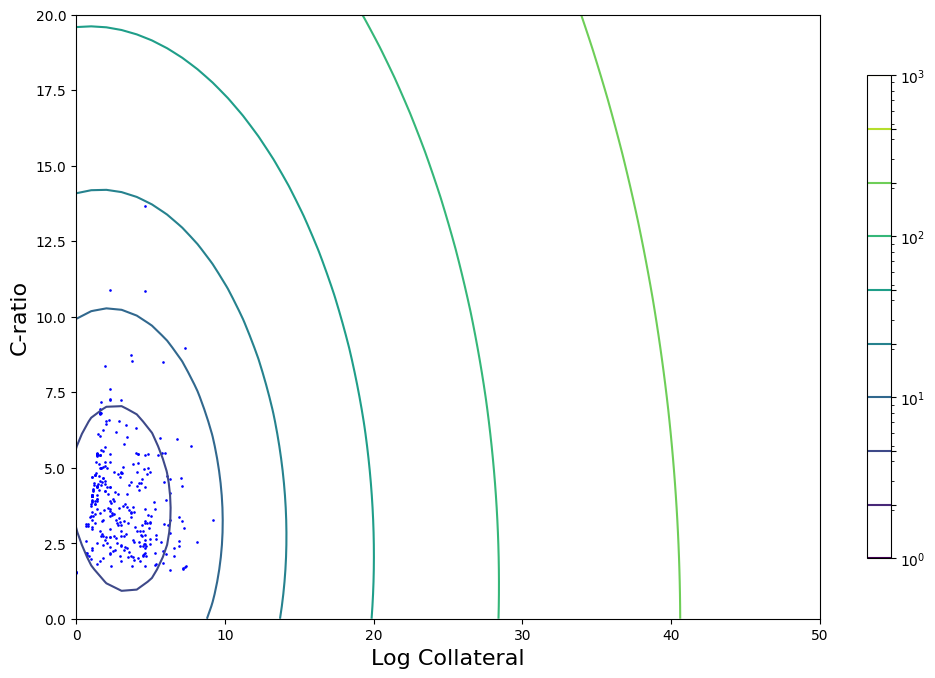

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from sklearn import mixture

# Create a Gaussian Mixture Model with one component
clf = mixture.GaussianMixture(n_components=1, covariance_type='full')

safes = orig_safes.copy()

# Transform collateral to make it normal
#pt = PowerTransformer()
#safes['collateral'] = pt.fit_transform(safes['collateral'].values.reshape(-1,1))
safes['collateral'] = np.log(safes['collateral'])

"""
safes['collateral'].hist(bins=100, color='blue', alpha=0.5, label='original')
plt.title('Transformed collateral')
plt.legend()
plt.grid(False)
plt.show()
"""

# Fit
clf.fit(safes[['collateral', 'cratio']])

# display predicted scores by the model as a contour plot
x = np.linspace(0, 50.)
y = np.linspace(0, 20.)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -clf.score_samples(XX)
Z = Z.reshape(X.shape)

CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                 levels=np.logspace(0, 3, 10))
CB = plt.colorbar(CS, shrink=0.8, extend='both')

plt.scatter(safes['collateral'], safes['cratio'], .8, color='blue')

#plt.title('Negative log-likelihood predicted by a GMM')
plt.axis('tight')
plt.xlabel('Log Collateral', fontsize=16)
plt.ylabel('C-ratio', fontsize=16)
plt.show()


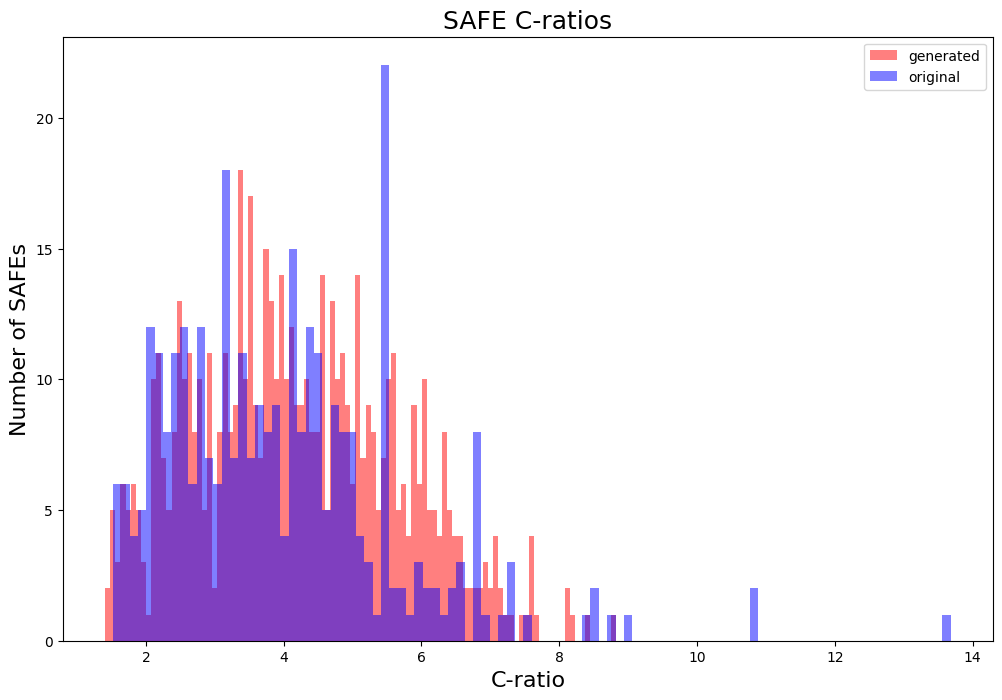

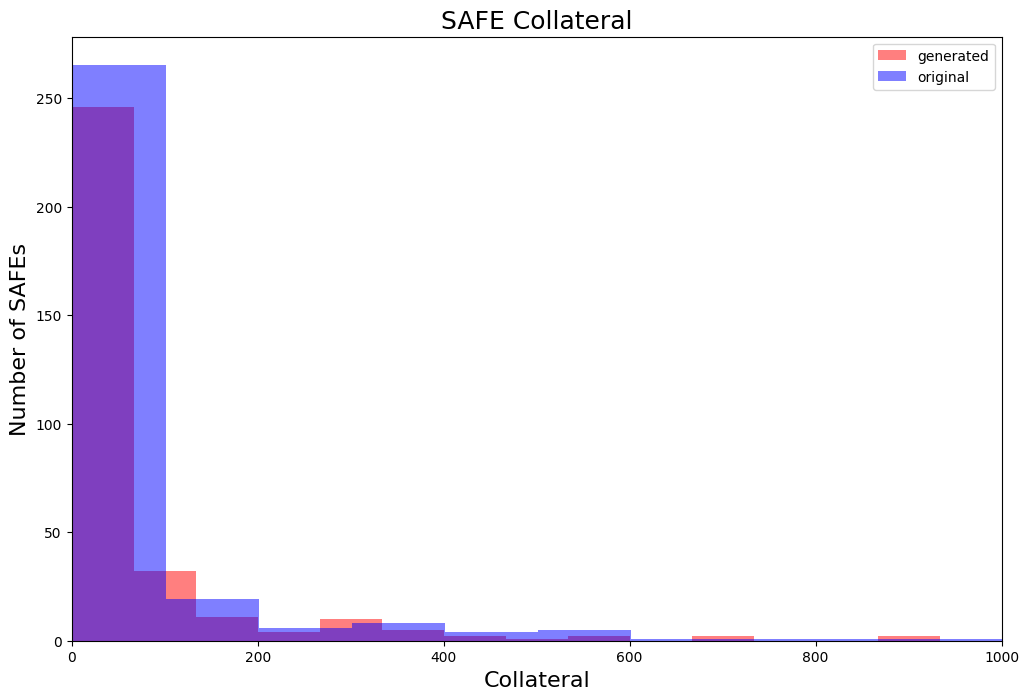

In [35]:
# C-ratios
sample = np.random.multivariate_normal(clf.means_[0], clf.covariances_[0], len(orig_safes)*2)
df = pd.DataFrame(sample, columns=['collateral', 'cratio'])
df = df[df['cratio'] > MAINNET_LIQ_RATIO]

df['cratio'].hist(bins=100, alpha=0.5, color='red', label='generated')

orig_safes['cratio'].hist(bins=100, color='blue', alpha=0.5, label='original')

plt.title('SAFE C-ratios', fontsize=18)
plt.xlabel('C-ratio', fontsize=16)
plt.ylabel('Number of SAFEs', fontsize=16)
plt.legend()
plt.grid(False)
plt.show()

# Collateral
sample = np.random.multivariate_normal(clf.means_[0], clf.covariances_[0], len(orig_safes)*2)
df = pd.DataFrame(sample, columns=['collateral', 'cratio'])
df = df[df['cratio'] > MAINNET_LIQ_RATIO]
df = df.head(len(orig_safes))

df['collateral'] = np.exp(df['collateral'])

df['collateral'].hist(bins=100, alpha=0.5, color='red', label='generated')

orig_safes['collateral'].hist(bins=100, alpha=0.5, color='blue', label='original')
plt.xlim([0, 1000])
plt.title('SAFE Collateral', fontsize=18)
plt.xlabel('Collateral', fontsize=16)
plt.ylabel('Number of SAFEs', fontsize=16)
plt.legend()
plt.grid(False)
plt.show()

## Sim #4: Prepare SAFEs

In [36]:
# Generate a population of SAFEs for each run

# draw random collateral and c-ratio values from distribution
all_gaussian_safes = [np.random.multivariate_normal(clf.means_[0], clf.covariances_[0], len(orig_safes)*2) for _ in range(N_RUNS)]

# Intialize SAFEs with random values
all_safes = [pd.DataFrame(gaussian_safe, columns=['collateral', 'cratio']) for gaussian_safe in all_gaussian_safes]

# Filter out unacceptable SAFEs
all_tmp_safes = []

for tmp_safes in all_safes:
    tmp_safes['collateral'] = np.exp(tmp_safes['collateral'])
    tmp_safes = tmp_safes[(tmp_safes['collateral'] > 0) & (tmp_safes['cratio'] > MAINNET_LIQ_RATIO)]
    
    tmp_safes = tmp_safes.head(len(orig_safes))
    assert len(tmp_safes) == len(orig_safes)
    
    tmp_safes['debt'] = tmp_safes['collateral'] * ETH_USD / REDEMPTION_PRICE / tmp_safes['cratio']    
    all_tmp_safes.append(tmp_safes)
    
# Draw more random collateral and c-ratio values
all_extra_gaussian_safes = [np.random.multivariate_normal(clf.means_[0], clf.covariances_[0], 1000) for _ in range(N_RUNS)]

# Generate more SAFEs to fill up to debt ceiling
final_sim4_safes = []
for idx, gaussian_safes in enumerate(all_extra_gaussian_safes):
    new_safes = pd.DataFrame(gaussian_safes, columns=['collateral', 'cratio'])
    new_safes['collateral'] = np.exp(new_safes['collateral'])
    
     # Filter out unacceptable samples
    new_safes = new_safes[(new_safes['collateral'] > 0) & (new_safes['cratio'] > MAINNET_LIQ_RATIO)]
    
    # Calculate debt
    new_safes['debt'] = new_safes['collateral'] * ETH_USD / REDEMPTION_PRICE / new_safes['cratio']
    
    # Only use enough SAFEs to fill `extra_debt`
    new_safes['total_debt'] = new_safes['debt'].cumsum()        
    final_safes = new_safes[new_safes['total_debt'] <= extra_debt]
    assert len(final_safes) > 0
    
    final_safes.drop('total_debt', axis='columns')
    
    tmp_safes = pd.concat([all_tmp_safes[idx], final_safes])
    final_sim4_safes.append(tmp_safes)

## Run All Sims

In [37]:
def process_results(df):
    for q in QUANTILES:
        print(f"{q=}")
        df_q = df[['lr', 'initial_surplus', 'shock', 'surplus']].groupby(['lr', 'initial_surplus', 'shock']).quantile(1. - q).reset_index()       
        df_q = df_q[df_q['surplus'] > 0]
        df_min = df_q.loc[df_q.groupby(['lr', 'initial_surplus'])['surplus'].idxmin()]
        print(df_min.head(100))            

In [38]:
for n_shocks in TOTAL_SHOCKS:
    print(f"{n_shocks=}")
    sim2_results = run_sims_iter(final_sim2_safes, total_shocks=n_shocks, title='', sim_name='sim2', verbose=VERBOSE, plot=PLOT)
    sim3_results = run_sims_iter(final_sim3_safes, total_shocks=n_shocks, title='', sim_name='sim3', verbose=VERBOSE, plot=PLOT)
    sim4_results = run_sims_iter(final_sim4_safes, total_shocks=n_shocks, title='', sim_name='sim4', verbose=VERBOSE, plot=PLOT)
    all_results = pd.concat([sim2_results, sim3_results, sim4_results])
    process_results(all_results)

n_shocks=1
q=0.9
       lr  initial_surplus  shock        surplus
31   1.20         493000.0   0.31    1151.530102
95   1.20        1000000.0   0.34  119219.070200
154  1.25         493000.0   0.32   81334.508089
218  1.25        1000000.0   0.35   76546.065229
277  1.30         493000.0   0.33  120085.321169
340  1.30        1000000.0   0.35  279865.126785
400  1.35         493000.0   0.34  161674.495108
463  1.35        1000000.0   0.36  196394.510202
523  1.40         493000.0   0.35  132939.436313
586  1.40        1000000.0   0.37  132783.121499
q=0.95
       lr  initial_surplus  shock        surplus
25   1.20         493000.0   0.25   18318.166201
88   1.20        1000000.0   0.27  106824.746543
147  1.25         493000.0   0.25  204137.997413
212  1.25        1000000.0   0.29   60308.432424
271  1.30         493000.0   0.27    8266.649417
335  1.30        1000000.0   0.30   62623.591699
394  1.35         493000.0   0.28   50753.800338
458  1.35        1000000.0   0.31   25748.472